## <center>Elements Of Data Science - F2021</center>
# <center>Week 7: Model Evaluation and Hyperparameter Tuning<center>
### <center>10/25/2021</center>

# TODOs

- Readings:
 - [PDSH Chapter 5: Feature Engineering](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html)
 - (Recommended) PML Chapter 4
<br>

- **Quiz 7**, due **Sunday Oct 31st, 11:59pm ET**

- **HW2**, due **Fri Nov 5th, 11:59pm ET**

- **Midterm**
  - Online via gradescope
  - Released Monday Oct 25th 11:59pm
  - Due Wednesday Oct 27th 11:59pm
  - Have 24hrs after starting exam to finish
  - 30-40 questions (fill in the blank/multiple choice/short answer)
  - Questions asked/answered **privately** via Ed
  - Open-book, open-note, open-python

# Today

- Model Evaluation and Selection
- Hyperparameter Tuning
- Regularization

<br>
<br>

# <center>Questions?</center>
<br>
<br>

# Environment Setup

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

sns.set_style('darkgrid')

%matplotlib inline

# Model Evaluation and Hyperparameter Tuning
<br>

- How well are any of our models working?
- How can we compare different models?
- How do we decide on hyperparameter settings?
- How can we keep our models from "overfitting"?
- How do we do all this both for Regression and Classification?

# How well are our models performing?

## Regression

- Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
- $R^2$ or `R^2`
- (Adjusted $R^2$ - will talk about during Feature Selection)

## Classification

- Accuracy
- Precision/Recall/F1
- ROC Area Under the Curve (AUC)

# Data Setup for Regression

In [2]:
zscore = lambda x: (x - x.mean()) / x.std()

df_wine = pd.read_csv('../data/wine_dataset.csv',
                      usecols=['alcalinity_of_ash','magnesium','alcohol','ash','proline','hue','class'])
numeric_cols = ['alcalinity_of_ash','magnesium','alcohol','ash','proline','hue']

df_wine[numeric_cols] = df_wine[numeric_cols].apply(zscore)  # standardize numeric feature cols

X = df_wine[['proline','hue','ash']]                       

y_r = df_wine['alcohol']                                     # regression target

In [3]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   alcohol            178 non-null    float64
 1   ash                178 non-null    float64
 2   alcalinity_of_ash  178 non-null    float64
 3   magnesium          178 non-null    float64
 4   hue                178 non-null    float64
 5   proline            178 non-null    float64
 6   class              178 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 9.9 KB


# Regression with Simple Linear Model

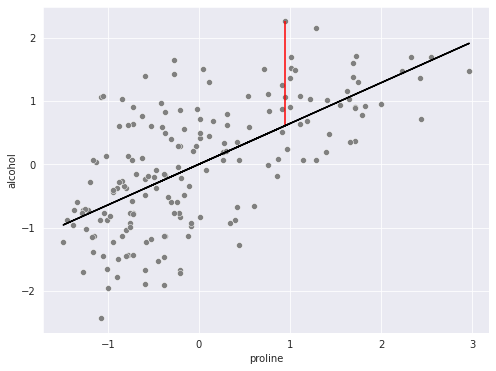

In [4]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X[['proline']],y_r)
argmax_y_r = np.argmax(y_r)
y_pred = lr.predict(X[['proline']])

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x=X.proline, y=y_r, color='grey');
ax.plot(X.proline,y_pred,color='k');
ax.vlines(X.proline.iloc[argmax_y_r],y_r.iloc[argmax_y_r],y_pred[argmax_y_r],color='r');

# How Good is This Fit? MSE and RMSE
<br>

- **Mean Squared Error:** $\frac{1}{n} \sum_i{(y_i - \hat{y}_i)^2}$

In [5]:
from sklearn.metrics import mean_squared_error

lr_mse = mean_squared_error(y_r,y_pred)
print(f'{lr_mse = :0.2f}')

lr_mse = 0.58


- But this is the squared error! (alcohol^2)
<br>

- **Root Mean Squared Error:** $\sqrt{ \frac {1}{n} \sum_i{(y_i-\hat{y}_i)^2} }$

In [6]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

lr_rmse = root_mean_squared_error(y_r,y_pred)
print(f'{lr_rmse = :0.2f}')

lr_rmse = 0.76


# Is this good? Need a Baseline Comparison
<br>

- What's a baseline to compare against?
- Simple one for Regression: always predict the mean of the targets

In [7]:
from sklearn.dummy import DummyRegressor

dummyr = DummyRegressor(strategy='mean') # default strategy
dummyr.fit(X[['proline']],y_r)

dummy_rmse = root_mean_squared_error(y_r,dummyr.predict(X[['proline']]))

print(f'{dummy_rmse = :0.2f}')

dummy_rmse = 1.00


# Comparing against the mean: $R^2$

- the proportion of variance explained by the model
<br>
<br>

<center>$\Large R^2 = 1 - \frac{\sum{(y_i - \hat{y}_i)^2}}{\sum(y_i - \bar{y})^2}$</center>
<br>

- maximum value of 1
- a value below 0 means the model is predicting worse than just predicting the mean
- sklearn uses $R^2$ as the default for regression scoring

In [8]:
r2_lr = lr.score(X[['proline']],y_r)
r2_dummyr = dummyr.score(X[['proline']],y_r)

print(f'{r2_dummyr = :0.2f}\n{r2_lr     = :0.2f}')

r2_dummyr = 0.00
r2_lr     = 0.41


# Can we do better?

In [9]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth=10)
dtr.fit(X[['proline']],y_r)
r2_dtr = dtr.score(X[['proline']],y_r)
print(f'{r2_lr  = :0.2f}\n{r2_dtr = :0.2f}')

r2_lr  = 0.41
r2_dtr = 0.76


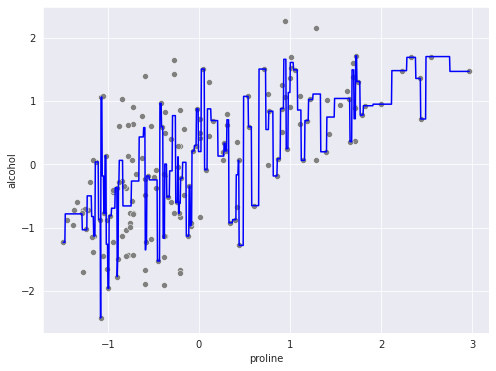

In [10]:
X_proline_sorted = X[['proline']].sort_values(by='proline').values
X_query = np.linspace(X_proline_sorted.min(),X_proline_sorted.max(),1000).reshape(-1,1)
y_pred = dtr.predict(X_query)
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(x=X.proline, y=y_r,color='gray');
ax.plot(X_query,y_pred,color='b');

# But is this what we want? Interpretation vs Prediction
<br>

Always good to ask:
- do we want our model to very closely fit our data for interpretation?
- do we want our model to predict well on new, unseen data?
<br>

**Generalization:**
- how well will model predict on data that it hasn't seen yet?
<br>

But we used all of our data to train?
- Need to do a **Train/Test Split** to create a held-aside set

# Train/Test Split
<br>

- **Training Set:** portion of dataset used for training
- **Test/Held-Aside/Out of sample:** portion of dataset used for evaluation
<br>

- Want the test set to reflect the same distribution as training
<bf>
<br>
    
<div align="center"><img src="images/train_test_split.png" width="600px"></div>

<font size=4>From https://www.researchgate.net/figure/Train-Test-Data-Split_fig6_325870973</font>

# Train/Test split with Sklearn

In [11]:
from sklearn.model_selection import train_test_split

X_train_r,X_test_r,y_train_r,y_test_r = train_test_split(X[['proline']],
                                                         y_r,
                                                         train_size=.75,  #default (only need one of train/test)
                                                         test_size=.25,   #default
                                                         random_state=123)
print(f"n_total = {X[['proline']].shape[0]}")
print(f'n_train = {X_train_r.shape[0]}')
print(f'n_test  = {X_test_r.shape[0]}')

n_total = 178
n_train = 133
n_test  = 45


- How big should test be? 
 - Large enough to capture variance of dataset.
 - Depends on the dataset and the models being trained

# Training and Evaluate on Different Data

In [12]:
dummyr = DummyRegressor().fit(X_train_r,y_train_r)
lr = LinearRegression().fit(X_train_r,y_train_r)
dtr = DecisionTreeRegressor(max_depth=10).fit(X_train_r,y_train_r)

r2_dummyr = dummyr.score(X_test_r,y_test_r)
r2_lr     = lr.score(X_test_r,y_test_r)
r2_dtr    = dtr.score(X_test_r,y_test_r)

print(f'{r2_dummyr = : 0.2f}\n{r2_lr     = : 0.2f}\n{r2_dtr    = : 0.2f}')

r2_dummyr = -0.03
r2_lr     =  0.28
r2_dtr    = -0.31


- DecisionTree model is doing worse than the Dummy model on the test set!

# Overfitting and Underfitting

- **Overfitting:** poor generalization due to complexity
 - learning noise in training data
<br>
<br>

- **Underfitting:** poor generalization due to simplicity
 - not flexibile enough to learn concept
<br>
<br>

- Need to find a balance between simplicity and complexity
- Need to find a balance between **bias** and **variance**


# Bias-Variance Tradeoff
<br>

<div align="center"><img src="images/05.03-bias-variance.png" width="1400px"></div>

From PDSH

# Bias-Variance Tradeoff
<br>

<div align="center"><img src="images/05.03-bias-variance-2.png" width="1400px"></div>

From PDSH

# Bias-Variance Tradeoff Continued
<br>

- How close is the model to the underlying concept?
- How sensitive is the model to the training set?

<div align="center"><img src="images/bias_variance_targets.jpeg" width="900px"></div>

# Bias-Variance Tradeoff Continued
<br>
<br>

<div align="center"><img src="images/bias-variance-tradeoff.png" width="800px"></div>

- We'd like to: 
 - reduce the Bias (use a model complex enough to capture the concept)
 - without introducing too much Variance (overfit the data)
 - all in order to minimize **Generalization Error**

# Overfitting/Underfitting Revisited
<br>

- **Overfitting:** poor generalization due to complexity
 - learning noise in training data
 - model has **high variance and low bias**


- **Underfitting:** poor generalization due to simplicity
 - not flexibile enough to learn concept
 - model has **high bias and low variance**

# Avoiding Overfitting/Underfitting

- Never train and evaluate on the same set of data!
 - train test split
 - **cross-validation**

- Keep the model as simple as possible (Occom's Razor)

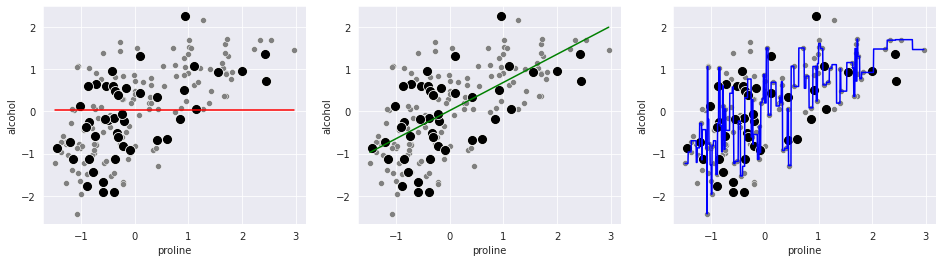

In [13]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    sns.scatterplot(x=X_train_r.proline,y=y_train_r,color="gray",ax=ax[i])
    sns.scatterplot(x=X_test_r.proline,y=y_test_r,color="black",s=100,ax=ax[i]);
ax[0].plot(X_query,dummyr.predict(X_query),color='r');
ax[1].plot(X_query,lr.predict(X_query),color='g');
ax[2].plot(X_query,dtr.predict(X_query),color='b');

# Overfitting? Simplify the model

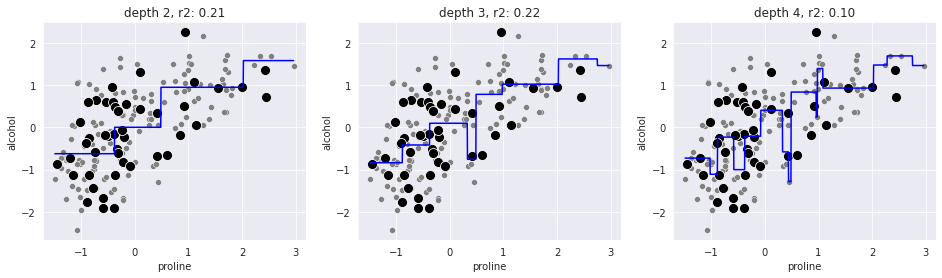

In [14]:
max_depths = [2,3,4]
fig,ax = plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    dtr = DecisionTreeRegressor(max_depth=max_depths[i]).fit(X_train_r,y_train_r)
    sns.scatterplot(x=X_train_r.proline,y=y_train_r,color="gray",ax=ax[i])
    sns.scatterplot(x=X_test_r.proline,y=y_test_r,color="black",s=100,ax=ax[i]);
    ax[i].plot(X_query,dtr.predict(X_query),color='b');
    ax[i].set_title(f'depth {max_depths[i]}, r2: {dtr.score(X_test_r,y_test_r):0.2f}')

- But now we might be overfitting on the test set!
- How to choose hyperparameters: **Cross-Validation**

# Aside: Hyperparameters
<br>
    
- **parameter:** something learned by the model itself (eg. coefficient in linear model)
<br>

- **hyperparameter:** something we set by hand (eg. decision tree max depth)

# $k$-Fold Cross-Validation
<br>

1. split dataset into $k$ equal sized subsets (folds)
2. for each subset (fold)
 - train on the other $k−1$ subsets combined 
 - test on this subset to get a score
3. average across all scores
<br>

- Result is a set of samples of model performance
- Can use to set hyperparameters without overfitting on train or test
- Can also use to estimate range of generalization performance

# Example: 10-Fold Cross-Validation
<br>

<div align="center"><img src="images/cv10fold.png" width="1000px"></div>

# k-Fold Cross-Validation Continued
<br>

- Can be used for:
 - tuning hyperparameters
 - model selection
 - any time we need estimate of model performance
<br>
<br>

- **Issue:** each fold requires training the model
 - Training time can be an issue for large $k$
<br>
<br>

- What values can $k$ take?
 - min: 2
 - max: $n$, the size of the dataset (aka Leave-One-Out CV)

# k-Fold Cross-Validation in sklearn

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeRegressor(max_depth=2),
                         X_train_r,
                         y_train_r,
                         cv=5) #default
scores

array([0.41853032, 0.37075208, 0.45405394, 0.2588269 , 0.22799476])

In [16]:
print(f'{np.mean(scores) :0.2f} +- {2*np.std(scores) :0.2f}')

0.35 +- 0.18


# Tuning Hyperparameters with CV

In [17]:
mean_scores = []

for depth in [1, 2, 3, 5, 10]:
    dtr = DecisionTreeRegressor(max_depth=depth)
    scores = cross_val_score(dtr,X_train_r,y_train_r,cv=5)
    mean_scores.append( (depth,scores.mean().round(3)) )

for depth,mean_score in mean_scores:
    print(f'{depth = :2d} : {mean_score: 0.3f}')

depth =  1 :  0.289
depth =  2 :  0.346
depth =  3 :  0.341
depth =  5 :  0.050
depth = 10 : -0.142


In [18]:
# find the depth that gives best score (highest R^2)
sorted(mean_scores, key=lambda x:x[1],reverse=True)[0] # sorted is ascending by default

(2, 0.346)

# Visualize Tuning: Validation Curve

**Validation Curve**
 - Show model complexity vs model performance on both train and test/validation
 - Want to find point where performance on validation set begins to decline (overfitting) 
 
<div align="center"><img src="images/05.03-validation-curve.png"></div>

From PDSH

# Validation Curve in sklearn

In [19]:
from sklearn.model_selection import validation_curve

depth = [1,2,3,5,8,10]
train_scores,test_scores = validation_curve(DecisionTreeRegressor(),
                                            X_train_r, y_train_r,
                                            param_name='max_depth',
                                            param_range=depth,
                                            cv=5)
mean_train_scores = np.mean(train_scores,axis=1) # take the mean across columns
mean_test_scores = np.mean(test_scores,axis=1)

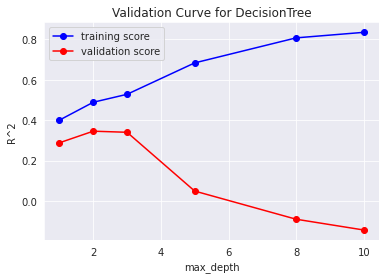

In [20]:
fig,ax = plt.subplots(1,1)
ax.plot(depth, mean_train_scores, 'o-', color='b',label='training score');
ax.plot(depth, mean_test_scores, 'o-', color='r', label='validation score');
ax.set_xlabel('max_depth'), ax.set_ylabel('R^2'); ax.set_title('Validation Curve for DecisionTree');
ax.legend();

# More Than One HyperParameter? Grid Search

**Grid Search:** Search over a 'grid' of hyperparameter settings

Example: KNN "number of neighbors" and "distance metric"

In [21]:
distance_metrics = ['euclidean','manhattan']
n_neighbors = [1,3,5]

grid = []
for d in distance_metrics:
    for k in n_neighbors:
        print([d,k])

['euclidean', 1]
['euclidean', 3]
['euclidean', 5]
['manhattan', 1]
['manhattan', 3]
['manhattan', 5]


# Grid Search in sklearn

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

params = {'n_neighbors':[1,2,3,5,10],
          'metric':['euclidean','manhattan']}
gscv = GridSearchCV(KNeighborsRegressor(),
                    param_grid=params,     # grid of size 10
                    cv=3,       # do 3-fold CV at every grid point
                    refit=True) # refit True trains one more time on the entire training set

gscv.fit(X_train_r,y_train_r)       # How many times are we training a model here? (2*5*3 + 1 = 31)

print(gscv.best_params_)

{'metric': 'euclidean', 'n_neighbors': 5}


In [23]:
scores = cross_val_score(gscv.best_estimator_,X_train_r,y_train_r,cv=5)

print(f'{np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')

0.35 +- 0.21


# Review So Far
<br>

- Regression Metrics
 - MSE and RMSE
 - $R^2$
- Model Selection
 - Comparison to Baseline Model
 - Underfitting/Overfitting, Bias/Variance
 - Train/Test Split
- Hyperparameter Tuning 
 - Cross-Validation
 - Grid Search
 - Validation Curve

# Data Setup for Classification

In [24]:
idx_binary = df_wine['class'].isin([0,1])               # reduce to binary classification

X_bc = df_wine.loc[idx_binary,['alcalinity_of_ash','magnesium']]         # only 2 features for ease of plotting
y_bc = df_wine.loc[idx_binary,'class']                   # pull out classification target [0,1]

X_train_bc,X_test_bc,y_train_bc,y_test_bc = train_test_split(X_bc,
                                                             y_bc,
                                                             stratify=y_bc, # maintain label proportions
                                                             random_state=0
                                                            )

pd.DataFrame({'train':y_train_bc.value_counts(),'test':y_test_bc.value_counts()}).sort_index()

,train,test
0,44,15
1,53,18


In [25]:
X_mc = df_wine.loc[:,['alcalinity_of_ash', 'magnesium']]      # multiple features for multiclass classification task
y_mc = df_wine.loc[:,'class']                                 # pull out classification target [0,1,2]
X_train_mc,X_test_mc,y_train_mc,y_test_mc = train_test_split(X_mc,
                                                             y_mc,
                                                             stratify=y_mc, # maintain label proportions
                                                             random_state=123
                                                            ) 
pd.DataFrame({'train':y_train_mc.value_counts(),'test':y_test_mc.value_counts()}).sort_values(by="train")

,train,test
2,36,12
0,44,15
1,53,18


# Default Metric in Classification: Accuracy
<br>


- **Accuracy**: out of all the observations, how many did I get right?

In [26]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
dummyc = DummyClassifier(strategy='prior').fit(X_train_bc,y_train_bc) # works like 'most-frequent'
dtc = DecisionTreeClassifier(max_depth=2).fit(X_train_bc,y_train_bc)

print(f'{dummyc.score(X_test_bc,y_test_bc) = :0.2f}') # default classification score is accuracy
print(f'{dtc.score(X_test_bc,y_test_bc)    = :0.2f}') 

dummyc.score(X_test_bc,y_test_bc) = 0.55
dtc.score(X_test_bc,y_test_bc)    = 0.79


- But what if the cost of calling a negative a positive is different from calling a positive a negative?
- Examples: 
 - disease testing
 - medical product failures
 - incarceration

# Errors in Classification
<br>

- There are different kinds of error in classification

<div align="center"><img src="images/confusion_matrix.png" width="600px"></div>

From PML

# Visualizing Errors with a Confusion Matrix

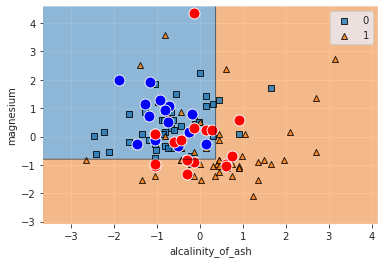

In [27]:
fig,ax = plt.subplots(1,1,figsize=(6,4));
plot_decision_regions(X_train_bc.values,y_train_bc.values,dtc,ax=ax);
sns.scatterplot(x=X_bc.columns[0],y=X_bc.columns[1],data=X_test_bc[y_test_bc == 0],color="blue",s=120);
sns.scatterplot(x=X_bc.columns[0],y=X_bc.columns[1],data=X_test_bc[y_test_bc == 1],color="red",s=120);

In [28]:
from sklearn.metrics import confusion_matrix

print('training set error\n', confusion_matrix(y_train_bc,dtc.predict(X_train_bc)))
print()
print('test set error\n', confusion_matrix(y_test_bc,dtc.predict(X_test_bc)))

training set error
 [[41  3]
 [14 39]]

test set error
 [[15  0]
 [ 7 11]]


# Plot Confusion Matrix with mlxtend

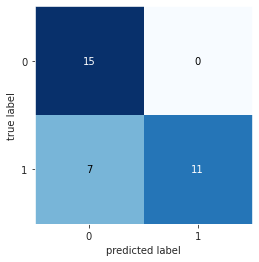

In [29]:
from mlxtend.plotting import plot_confusion_matrix

fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_confusion_matrix(confusion_matrix(y_test_bc,dtc.predict(X_test_bc)),axis=ax);

# Weighing Errors: Precision vs. Recall
<br>

**Precision**

- Out of the observations I predicted positive (TP+FP), how many are truly positive (TP)?
<br>

<center>$\large precision=\frac{\text{TP}}{\text{TP}+\text{FP}}$</center>

**Recall**

- Out of the truly positive (TP+FN), how many obsersevations did I predict positive (TP)?
<br>

<center>$\large recall=\frac{\text{TP}}{\text{TP}+\text{FN}}$</center>


# Using Other Measures in sklearn

In [30]:
dummyc_precision_scores = cross_val_score(dummyc,X_train_bc,y_train_bc,cv=5,scoring='precision')
dummyc_recall_scores    = cross_val_score(dummyc,X_train_bc,y_train_bc,cv=5,scoring='recall')

print(f'dummy precision: {np.mean(dummyc_precision_scores):0.2f} +- {2*np.std(dummyc_precision_scores):0.2f}')
print(f'dummy recall   : {np.mean(dummyc_recall_scores):0.2f} +- {2*np.std(dummyc_recall_scores):0.2f}')
print()

dtc_precision_scores = cross_val_score(dtc,X_train_bc,y_train_bc,cv=5,scoring='precision')
dtc_recall_scores    = cross_val_score(dtc,X_train_bc,y_train_bc,cv=5,scoring='recall')

print(f'dtc precision  : {np.mean(dtc_precision_scores):0.2f} +- {2*np.std(dtc_precision_scores):0.2f}')
print(f'dtc recall     : {np.mean(dtc_recall_scores):0.2f} +- {2*np.std(dtc_recall_scores):0.2f}')

dummy precision: 0.55 +- 0.04
dummy recall   : 1.00 +- 0.00

dtc precision  : 0.85 +- 0.36
dtc recall     : 0.66 +- 0.38


# How do we decide if something is positive or negative?
<br>

Usually set a threshold :

$$
\hat{y}_i = \begin{cases}
1 &\text{if } P(y_i=1|x_i) > \text{threshold}, \\\\
0 &\text{o.w.}
\end{cases}
$$

Usually, threshold = .5, but it doesn't have to be.

What happens if we change it?
 - High threshold $\rightarrow$ High Precision, Low Recall
 - Low threshold $\rightarrow$ High Recall, Low Precision

# Combining Precision and Recall: $F_1$-score
    
    
Usually, we just want one number to optimize

**$F_1$-score:** harmonic mean of precision and recall
- eg. weighted average of the precision and recall

$$
F_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$


Note that $F_1$ ignores True Negatives!

In [31]:
dummyc_f1_scores = cross_val_score(dummyc,X_train_bc,y_train_bc,cv=5,scoring='f1')
dtc_f1_scores = cross_val_score(dtc,X_train_bc,y_train_bc,cv=5,scoring='f1')
print(f'dummyc f1 = {np.mean(dummyc_f1_scores):0.2f} +- {2*np.std(dummyc_f1_scores):0.2f}')
print(f'dtc f1    = {np.mean(dtc_f1_scores):0.2f} +- {2*np.std(dtc_f1_scores):0.2f}')

dummyc f1 = 0.71 +- 0.03
dtc f1    = 0.72 +- 0.31


# Paying attention to True Negatives: ROC

**R**eceiver **O**perating **C**haracteristic
- displays FPR vs TPR

False Positive Rate (FPR) = $\frac{\text{FP}}{\text{FP}+\text{TN}}$ = $\frac{\text{negatives we got wrong}}{\text{all negatives}}$

True Positive Rate (TPR) = Recall = $\frac{\text{TP}}{\text{TP}+\text{FN}}$ = $\frac{\text{positives we got right}}{\text{all positives}}$

How do these change as we move our threshold?


In [32]:
from sklearn.metrics import roc_curve
fpr_dtc, tpr_dtc, _ = roc_curve(y_train_bc, dtc.predict_proba(X_train_bc)[:,-1])

fpr_dtc,tpr_dtc

(array([0.        , 0.        , 0.06818182, 1.        ]),
 array([0.        , 0.56603774, 0.73584906, 1.        ]))

# Plotting ROC Curves

In [33]:
def plot_roc(curves):
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    lw = 2
    for fpr,tpr,model_name in curves:
        l1, = ax.plot(fpr, tpr, lw=lw, label=model_name)
    ax.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_aspect('equal', 'box')
    ax.set_title('Receiver operating characteristic example')
    ax.legend()

# Plotting ROC Curves

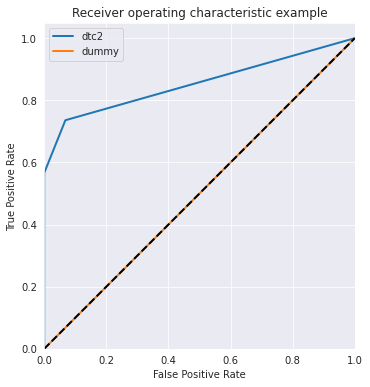

In [34]:
curves = [(fpr_dtc,tpr_dtc,'dtc2')]
fpr_dummyc, tpr_dummyc, _ = roc_curve(y_train_bc, dummyc.predict_proba(X_train_bc)[:,1]) # Compare dummy
curves.append((fpr_dummyc,tpr_dummyc,'dummy'));
plot_roc(curves);

# Plotting ROC Curves

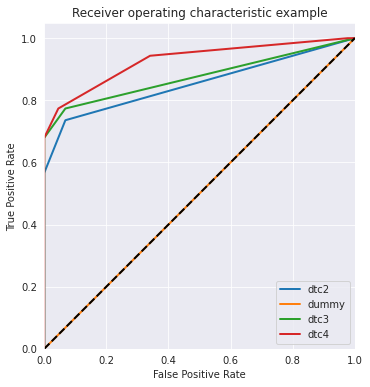

In [35]:
for depth in [3,4]: 
    fpr, tpr, _ = roc_curve(y_train_bc,DecisionTreeClassifier(max_depth=depth).fit(X_train_bc,y_train_bc).predict_proba(X_train_bc)[:,1])
    curves.append((fpr,tpr,'dtc'+str(depth)))
plot_roc(curves);

# ROC AUC

- But again, we'd like one number to optimize
- ROC **A**rea **U**nder the **C**urve
 - How much area falls under the ROC curve?

In [36]:
dummyc_rocauc_scores = cross_val_score(dummyc,X_train_bc,y_train_bc,cv=5,scoring='roc_auc')
dtc_rocauc_scores = cross_val_score(dtc,X_train_bc,y_train_bc,cv=5,scoring='roc_auc')

print(f'dummyc rocauc = {np.mean(dummyc_rocauc_scores):0.2f} +- {2*np.std(dummyc_rocauc_scores):0.2f}')
print(f'dtc rocauc    = {np.mean(dtc_rocauc_scores):0.2f} +- {2*np.std(dtc_rocauc_scores):0.2f}')

dummyc rocauc = 0.50 +- 0.00
dtc rocauc    = 0.78 +- 0.22


# Review: Steps to Choosing a Model

1. Create Held-Aside Set (Train/Test Split)
2. Determine Metric (or combination of metrics)
3. Get a Baseline for comparison
3. Use Cross-Validation to fit Hyperparameters and Choose Model
3. Evaluate Chosen Model on Held-Aside Set
<br>

<div align="center"><img src="images/train_tune_test.png" width="600px"></div>

From PML

# Avoiding Overfitting in Linear Models: Regularization
<br>

- Use to avoid overfitting in linear models
- Idea: can we reduce complexity of our linear model by minimizing weights?
<br>

<div align="center"><img src="images/Regularization.png" width="600px"></div>
    
From https://www.wikiwand.com/en/Regularization_(mathematics)

# Regression: Finding the Weights
<br>

- Linear models learn by finding weights that minimize a cost.
- Can we get close to the solution while still keeping weights small (simpler model)?
<br>
<br>

<div align="center"><img src="images/regularization_minimizecost.png" width="700px"></div>

From PML

# Regularization: Add a cost for large weights
<br>

Penalizing extreme weights (w)

If the original cost function looks like:

<center>$\arg\min_w C(f(w,x),y)$</center>

we can add a **regularization term**:

<center>$\arg\min_w C(f(w,x),y)+\lambda g(w)$</center>

# Regularization: Ridge

- Coefficients are encouraged to be "small"
- Uses $L_2$ norm: $\Vert w\Vert_2 = \sqrt{\sum_{j=1}^m w_j^2}$

<div align="center"><img src="images/regularization_L2.png" width="700px"></div>

From PML

# Regularization: LASSO

- Coefficients are (likely) driven to zero
- Uses $L_1$ norm: $\Vert w\Vert_1 = \sum_{j=1}^m \mid w_j \mid$

<div align="center"><img src="images/regularization_L1.png" width="700px"></div>

From PML

# Regularization: ElasticNet

- Mixture of $L_1$ and $L_2$
- $\alpha L_1 + (1-\alpha)L_2$
<br>

- introduces a new hyperparameter $\alpha$ or `l1_ratio`
- $\text{l1_ratio} = 1$ is LASSO ($L_1$)
- $\text{l1_ratio} = 0$ is Ridge ($L_2$)

# Regularization in sklearn

In [37]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(penalty='l2', # default
                          C=1.0,        # weight on regularization, 1/lambda above
                          l1_ratio=None # only used when penalty is 'elasticnet'
                         )

In [38]:
for C in [.001,.1,1,10,1000]:
    logr = LogisticRegression(penalty='l2', # default
                              C=C,          # weight on regularization, 1/lambda above
                         ).fit(X_train_bc,y_train_bc)
    print(f'{str(C):5s} : {logr.coef_[0].round(2)}')

0.001 : [ 0.02 -0.02]
0.1   : [ 0.69 -0.57]
1     : [ 1.09 -0.93]
10    : [ 1.19 -1.02]
1000  : [ 1.2  -1.03]


In [39]:
for C in [.001,.1,1,10,1000]:
    logr = LogisticRegression(penalty='l1',
                              C=C,          # weight on regularization, 1/lambda above
                              solver='liblinear'
                         ).fit(X_train_bc,y_train_bc)
    print(f'{str(C):5s} : {logr.coef_[0].round(2)}')

0.001 : [0. 0.]
0.1   : [ 0.5  -0.37]
1     : [ 1.08 -0.92]
10    : [ 1.19 -1.02]
1000  : [ 1.2  -1.03]


# GridSearchCV with Regularization

In [40]:
param_grid = {'l1_ratio':[0,.5,1],
              'C': [.001,.01,1,10]}
logr_gscv = GridSearchCV(estimator=LogisticRegression(penalty='elasticnet',solver='saga'),
                         param_grid=param_grid,
                         cv=3,
                         n_jobs=-1).fit(X_train_bc,y_train_bc)

print(f'best parameter setting found: {logr_gscv.best_params_}')
print(f'best coefficients found     : {logr_gscv.best_estimator_.coef_[0]}')
print(f'best training score found   : {logr_gscv.best_score_.round(3)}')

logr_gscv_test_score = logr_gscv.score(X_test_bc,y_test_bc)
logr_noreg_test_score = (LogisticRegression(penalty='none')
                         .fit(X_train_bc,y_train_bc)
                         .score(X_test_bc,y_test_bc)
                        )
print()
print(f'logr_gscv test score  : {logr_gscv_test_score.round(3)}')
print(f'logr noreg test score : {logr_noreg_test_score.round(3)}')


best parameter setting found: {'C': 1, 'l1_ratio': 1}
best coefficients found     : [ 1.09869298 -0.92783058]
best training score found   : 0.825

logr_gscv test score  : 0.818
logr noreg test score : 0.818


# ElasticNetCV

In [41]:
from sklearn.datasets import make_regression
from sklearn.linear_model import ElasticNetCV

X_synth,y_synth = make_regression(n_samples=100,
                                  n_features=200,
                                  n_informative=10,
                                  random_state=123
                                 )
X_synth_train,X_synth_test,y_synth_train,y_synth_test = train_test_split(X_synth, y_synth, random_state=123)

dummy_synth = DummyRegressor(strategy='mean').fit(X_synth_train,y_synth_train)
lr_synth = LinearRegression().fit(X_synth_train,y_synth_train)
en_synth = ElasticNetCV(alphas=[.01,.1,1,100]).fit(X_synth_train,y_synth_train)

print(f'found alpha: {en_synth.alpha_}, found l1_ratio: {en_synth.l1_ratio_}\n')
print(f'{dummy_synth.score(X_synth_train,y_synth_train) = : 0.2f}')
print(f'{lr_synth.score(X_synth_train,y_synth_train)    = : 0.2f}')
print(f'{en_synth.score(X_synth_train,y_synth_train)    = : 0.2f}\n')
print(f'{dummy_synth.score(X_synth_test,y_synth_test)   = : 0.2f}')
print(f'{lr_synth.score(X_synth_test,y_synth_test)      = : 0.2f}')
print(f'{en_synth.score(X_synth_test,y_synth_test)      = : 0.2f}')

found alpha: 1.0, found l1_ratio: 0.5

dummy_synth.score(X_synth_train,y_synth_train) =  0.00
lr_synth.score(X_synth_train,y_synth_train)    =  1.00
en_synth.score(X_synth_train,y_synth_train)    =  0.95

dummy_synth.score(X_synth_test,y_synth_test)   = -0.00
lr_synth.score(X_synth_test,y_synth_test)      =  0.16
en_synth.score(X_synth_test,y_synth_test)      =  0.24


<br>
<br>

# <center>Questions?</center>
<br>
<br>